# Day 24
In a notebook because there is a lot of exploration to find the answer

In [1]:
import time
from collections import defaultdict, Counter
from aocd.models import Puzzle
from dotenv import load_dotenv
from operator import and_, or_, xor
from functools import cache

load_dotenv()

True

In [2]:
puzzle = Puzzle(2024, 24)
data = puzzle.input_data

operators = {
    "AND": and_,
    "OR": or_,
    "XOR": xor,
}

wires_str, gates_str = data.strip().split("\n\n")

wires = {}
for line in wires_str.split("\n"):
    wire, val = line.split(": ")
    wires[wire] = bool(int(val))

gates = {}
for line in gates_str.split("\n"):
    gate, wire = line.split(" -> ")
    wire1, op, wire2 = gate.split()
    gates[wire] = (op, tuple(sorted([wire1, wire2])))

z_wires = sorted([z for z in gates if z.startswith("z")])
len_z = len(z_wires)

x_wires = sorted([w for w in wires if w.startswith("x")])
y_wires = sorted([w for w in wires if w.startswith("y")])
assert len(x_wires) == len(y_wires)
assert len_z == len(x_wires) + 1

# Part 1

In [3]:
start_time = time.time()


@cache
def calculate(wire):
    if wire in wires:
        return wires[wire]
    op, (wire1, wire2) = gates[wire]
    res = operators[op](calculate(wire1), calculate(wire2))
    # print(wire, res)
    return res


# print(wires)
outputs = [calculate(wire) for wire in z_wires]


def bools_to_int(bools):
    return sum([b << i for i, b in enumerate(bools)])


ans1 = bools_to_int(outputs)

timer = time.time() - start_time
print(f"{ans1=}, {timer=:.2f}s")

ans1=55920211035878, timer=0.00s


# Part 2
Binary addition can be done as follows (for z01-z44).

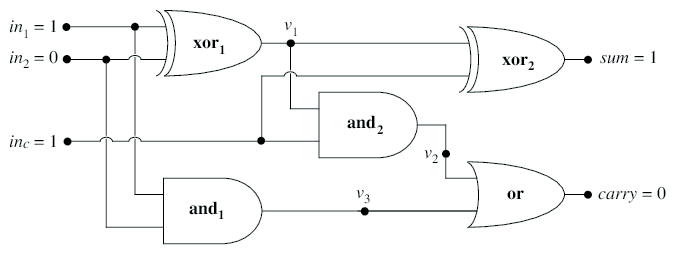

The first (z00) and last(z45) are different

In [4]:
assert gates["z00"] == ("XOR", ("x00", "y00"))
assert gates["z45"][0] == "OR"

In [5]:
# some helpers for easy lookup:
gates_inv = {v: k for k, v in gates.items()}


def get_out_wire(op, in1, in2):
    return gates_inv[(op, tuple(sorted([in1, in2])))]


# all wires this wire is an input to
gates_map = defaultdict(list)
for out, (_, (w1, w2)) in gates.items():
    gates_map[w1].append(out)
    gates_map[w2].append(out)
gates_map = dict(gates_map)

I'm not sure whether the above is the only way to create addition. I would think it's possible to do the same in a less efficient way (with more gates). Let's check if this is indeed the structure by counting the number of gates:

In [6]:
Counter(x[0] for x in gates.values())

Counter({'XOR': 89, 'AND': 89, 'OR': 44})

That confirms that it uses the schema above: 44 * (2 XOR, 2 AND, 1 OR) + 1 XOR (z00) + 1 AND (c00, first carry).
Note that z45 is equal to c44

I'm also guessing that Part 1 might provide a hint as to where the problems are. Let's do the sum:

In [7]:
def get_input(xy):
    wire_names = [f"{xy}{j:02}" for j in range(len_z - 1)]
    return bools_to_int([wires[w] for w in wire_names])


inputs = [get_input(xy) for xy in "xy"]

for input in inputs:
    print(f"{input:-46b}    {input:-15d}")
print(f"{'-'*(len_z)} +  {'-'*15} +")
sum_val = sum(inputs)
print(f"{sum_val:-45b}    {sum_val:-15d} <= correct solution")
print(f"{ans1:-45b}    {ans1:-15d} <= part 1 answer")

vals = [f"{v:045b}" for v in (sum_val, ans1)]
error_markers = "".join("." if a == b else "*" for a, b in zip(*vals))
print(f"{error_markers} <= differences at *")

# err_locs=[45-ix for ix,(a,b) in enumerate(zip(*vals)) if a!=b]
# print(f"{err_locs=}")

 110011011101111111100101100000101111011001101     28295188995789
 110001101111111110011000111100010100000011001     27350135613465
---------------------------------------------- +  --------------- +
1100101001101111101111110011101000011011100110     55645324609254 <= correct solution
1100101101101111110000010100001000011011100110     55920211035878 <= part 1 answer
.......*.........******..****................. <= differences at *


We see 3 distinct regions with errors. That doesn't help a lot (I was hoping for 4)

In binary addition, z[j] will (only) depend on all x[i] and y[i] for i<=j. 
We can check whether that's true to get a better sense of where the swaps may be

In [8]:
def find_deps(wire):
    if wire in wires:
        return set([wire])
    op, (wire1, wire2) = gates[wire]
    return find_deps(wire1) | find_deps(wire2)


for j in range(len_z - 1):
    z = f"z{j:02}"
    deps = find_deps(z)
    expected = set([f"{xy}{i:02}" for i in range(j + 1) for xy in "xy"])
    if deps != expected:
        print(f"incorrect deps for {z}:")
    missing = expected - deps
    if missing:
        print(f"* missing: {sorted(missing)}")
    spurious = deps - expected
    if spurious:
        print(f"* spurious: {sorted(spurious)}")

incorrect deps for z30:
* missing: ['x00', 'x01', 'x02', 'x03', 'x04', 'x05', 'x06', 'x07', 'x08', 'x09', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'y00', 'y01', 'y02', 'y03', 'y04', 'y05', 'y06', 'y07', 'y08', 'y09', 'y10', 'y11', 'y12', 'y13', 'y14', 'y15', 'y16', 'y17', 'y18', 'y19', 'y20', 'y21', 'y22', 'y23', 'y24', 'y25', 'y26', 'y27', 'y28', 'y29']


So only z30 is an exception. For everything else, all the deps are ok. That means that all swaps must happen within one *group*. It also means that all the carry's are in the right order. That makes things a lot easier.

z30 is a special case, as we can see:

In [9]:
gates["z30"]

('AND', ('x30', 'y30'))

We found our first element to swap! Since every z should come out of an OR gate, we can look for similar ones:

In [10]:
wrong_z = [
    out
    for out, (op, _) in gates.items()
    if out.startswith("z") and op != "XOR" and out != "z45"
]
wrong_z

['z23', 'z17', 'z30']

These 3 need to be swapped with a XOR gate.
Since it's all within the same group, we can simply go up 2 XOR gates from x[i],y[i] 

In [11]:
def replacement(z):
    num_str = z[1:]
    x, y = (xy + num_str for xy in "xy")
    xor_out = get_out_wire("XOR", x, y)
    result_gates = gates_map[xor_out]
    return next(g for g in result_gates if gates[g][0] == "XOR")


replacements_z = [replacement(z) for z in wrong_z]
res = wrong_z + replacements_z
replacements_z

['rmj', 'cmv', 'rdg']

6 down, 2 to go. Let's try some more things to find a wrong gate. 
Let's see if the number of gates that uses the result is correct 

In [12]:
to_swap = []

expected_lens = {
    "AND": 1,  # both only used in 1 OR gate
    "XOR": 2,  # not true for the XOR gate that produces z, but that one we ignore anyway
    "OR": 2,  # except for the last one, but that's ignored because it produces z45
}
for gate, (op, (in1, in2)) in gates.items():
    if gate in res:
        continue
    if gate.startswith("z"):
        continue
    if in1 == "x00":
        continue

    expected_len = expected_lens[op]
    out_gates = gates_map[gate]
    if len(out_gates) != expected_len:
        to_swap.append(gate)

res += to_swap
to_swap

['mwp', 'btb']

Found them all!

In [13]:
ans2 = ",".join(sorted(res))
timer = time.time() - start_time
print(f"{ans2=}, {timer=:.2f}s")

ans2='btb,cmv,mwp,rdg,rmj,z17,z23,z30', timer=0.24s


# Check
we can perform all the swaps and check that the gates are all as expected.

I used this to locate some of the wrong gates

In [14]:
gates2 = gates.copy()


def swap(g1, g2):
    gates2[g1], gates2[g2] = gates2[g2], gates2[g1]


for g1, g2 in zip(wrong_z, replacements_z):
    swap(g1, g2)
swap(*to_swap)

gates_inv2 = {v: k for k, v in gates2.items()}


def get_out_wire2(op, in1, in2):
    return gates_inv2[(op, tuple(sorted([in1, in2])))]


carry = get_out_wire2("AND", "x00", "y00")

for j in range(1, 45):
    x, y, z = (f"{w}{j:02}" for w in "xyz")
    and_out = get_out_wire2("AND", x, y)
    xor_out = get_out_wire2("XOR", x, y)
    and2_out = get_out_wire2("AND", carry, xor_out)
    xor2_out = get_out_wire2("XOR", xor_out, carry)
    assert xor2_out == z
    carry = get_out_wire2("OR", and_out, and2_out)

assert carry == "z45"